In [29]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import momepy
import numpy as np
import networkx as nx
import osmnx as ox
import matplotlib.cm as cm
from scipy.interpolate import UnivariateSpline

## How Angela Would Code This

### Build Network

In [30]:
'''
Calculates capacities based on safe breaking distances and a paper from Moore et al (2013) 
and then appends this attributed to the graph G. [ code adapted from Mike Schimidt ]
'''

MOORE_AFTER_BREAK_SPLINE = UnivariateSpline(
    [20, 30, 40, 50, 60, 70, 80, 90, 100],
    [3.9, 6, 11, 18, 27, 39, 54, 58, 84],
)
MOORE_BEFORE_BREAK_SPLINE = UnivariateSpline(
    [20, 30, 40, 50, 60, 70, 80, 90, 100],
    [6, 8, 11, 14, 17, 19, 22, 25, 28],
)

MOORE_SAFE_BREAKING_DISTANCE = lambda x: MOORE_AFTER_BREAK_SPLINE(
    x
) + MOORE_BEFORE_BREAK_SPLINE(x)

#this uses the speed_kph attribute of the graph to calculate the moore capacities 
def moore(lanes: float, max_speed: float):
    return 1000 * max_speed / MOORE_SAFE_BREAKING_DISTANCE(max_speed) * lanes

'''
Adds capacities to multidigraph G using moore method from above [ code adapted from Mike Schimidt ]
'''
def add_capacities(G, method=moore):

    G = G.copy()
    cap = []
    
    for u, v, i in G.edges:
        edge_data = G.get_edge_data(u, v, i)
        raw_lanes = edge_data.get("lanes")
        
        if raw_lanes is None:
            lanes = 1
            
        elif isinstance(raw_lanes, str):
            lanes = int(raw_lanes) / 2  
            
        elif isinstance(raw_lanes, list):
            lanes = sum(int(x) for x in raw_lanes) / 2
            
        edge_data["capacity"] = int(method(lanes, edge_data["speed_kph"]))
        
        val = edge_data["capacity"]
        #print('val',val)
 
        cap.append(val)
    return (cap,G)

'''
Building the Graph
'''
def build_graph(city_state, tol_amt):
#     to_crs='epsg:4326'
    G = ox.project_graph(ox.graph_from_place(city_state, network_type='drive'))
#     G = ox.graph_from_place(city_state, network_type='drive',simplify = False, retain_all = True)
    G = ox.simplification.consolidate_intersections(G, tolerance=tol_amt, rebuild_graph=True, dead_ends=True, reconnect_edges = True)
    G = ox.speed.add_edge_speeds(G)
    G = ox.speed.add_edge_travel_times(G)
    edge_data,G =add_capacities(G)
    
    
    return G

### Choose Source and Sink

In [31]:
##switch statement to choose origin and destination lat and long
def switch(key):
    if key == "Boulder":
        return (479800,4424260,489130,4429760)
    elif key == "Pueblo":
        return (5255180,4250280,514380,4423270)
    elif key == "Lyons":
        return (477230,4453570,476140,4430890)
    elif key == "Jefferson":
        return (489685,4379999,494940,4393420)
    elif key == "Sonoma":
        return (512007,4273277,525300,4255270)
    elif key == "Butte":
        return (621540,4406520,599230,4400090)
    else:
        raise Exception("Please enter a valid location.")
        exit()

###find nodes in network closestest to desired destinations
def s_t_nodes(network, location):
    lat_start,long_start,lat_end,long_end = switch(location)
    orig=ox.distance.nearest_nodes(network,lat_start,long_start,return_dist=False)
    dest=ox.distance.nearest_nodes(network,lat_end,long_end,return_dist=False)
    return orig, dest

### Using Networkx Functions for Making Residual Network

In [32]:
'''
Find Delta Flow for Path
'''
def delta_flow(G,path):
    caps = []
    for i in range(len(path)-1):
        j = path[i]
        k = path[i+1]
        
        caps.append(G[j][k][0]['capacity'])

    delta = min(caps)
    return delta
            

In [33]:
'''
Augment Flow Along Path/Update Residual Network
'''
def update_resid(G,path,delta):
    for i in range(len(path)-1):
        j = path[i]
        k = path[i+1]
    
        ###reverse edge if capacity filled up
        if G[j][k][0]['capacity']-delta == 0:
            if G.has_edge(k,j)==False:
                attrs = G[j][k][0]
                keys = attrs.keys()
                G.remove_edge(j,k)
                G.add_edge(k,j)
                for m in keys:
                    G[k][j][0][m]=attrs[m]
                G[k][j][0]['capacity']=delta
            else:
                G.remove_edge(j,k)
                G[k][j][0]['capacity']+=delta
                
        ###Add in residual edge and/or adjust capacities accordingly
        else:
            G[j][k][0]['capacity'] -=delta
            if G.has_edge(k,j)==False:
                attrs = G[j][k][0]
                keys = attrs.keys()
                G.add_edge(k,j)
                for m in keys:
                    G[k][j][0][m]=attrs[m]
                G[k][j][0]['capacity']=delta
            else:
                G[k][j][0]['capacity']+=delta
    return G


### Generic Augmenting Path Algorithm

In [34]:
###build network
net = build_graph('Butte California', 10)
#make a copy for plotting purposes
net_original=net.copy()

###set origin and destination
orig,dest=s_t_nodes(net,"Butte")

###amount to be sent
pop = 10000
### list to stort shortest paths
paths = []

###GAP Algorithm
while pop > 0:
    ##find shortest path
    shortest_path=ox.distance.shortest_path(net, orig, dest, weight='travel_time')
    
    if shortest_path is not None:
        paths.append(shortest_path)
        
        ##find flow
        delta = delta_flow(net,shortest_path)
    
        ##update residual network
        net = update_resid(net,shortest_path,delta)
        
        ##update pop
        pop -=delta
    else:
        break

### Plotting Functions

In [35]:
'''
Gets n evenly spaced colors to map the different path with from the colormap 'hsv'
'''

def get_colors(n, cmap='hsv', start=0., stop=1., alpha=1.):

    colors = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    colors = [(r, g, b, alpha) for r, g, b, _ in colors]
    return colors

In [18]:
'''
Plot all the shortest paths
'''
def plot_s_t_paths(sp_list,G):
#     ec=ox.plot.get_edge_colors_by_attr(G, attr="capacity")
    if len(sp_list)>1:
        cl=np.array(get_colors(len(sp_list)))
        fig, ax = ox.plot_graph_routes(G, sp_list, route_colors=cl, route_linewidth=6, node_size=2, show = False, close = False)
#         print(ax)
#         ax.plot(39.659850,-121.629890,  'go', linewidth=2, markersize=50)
#         plt.show()
    else:  
        fig, ax = ox.plot_graph_route(G, sp_list[0], route_color='y', route_linewidth=6, node_size=2, edge_color=ec)
#         plt.show()
#     ax.plot(0.1, 0.1, 'go', linewidth=2, markersize=50)
    plt.show()
    return (fig, ax)

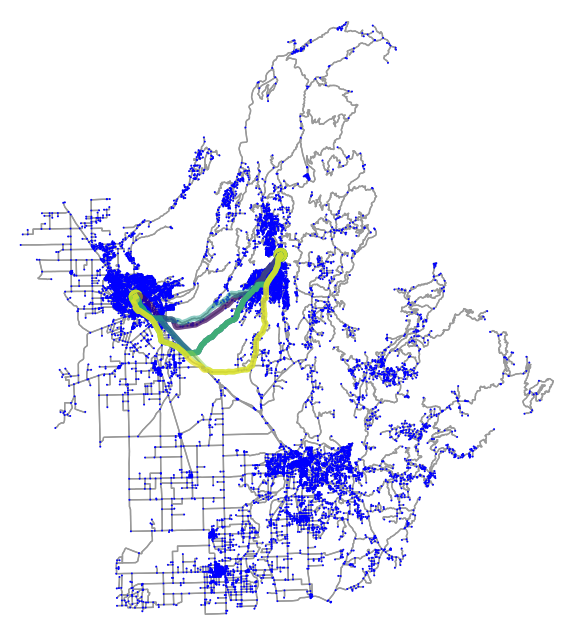

In [79]:
# fig,ax = plot_s_t_paths_v2(paths, net_original)
cl = np.array(ox.plot.get_colors(len(paths),return_hex = True))
fig,ax=ox.plot_graph_routes(net_original, paths, route_colors=cl, route_linewidth=6, node_size=2,bgcolor='w',node_color='b',show=False, close=False)
points_proj.plot(ax=ax, markersize = 50, color = "red")
plt.show()

In [82]:
# fig,ax=ox.plot_graph(net_original,show=False, close=False)
# ax.scatter(621540,4406520, c = 'red')
# points_proj.plot(ax=ax, c = 'r'
# ax.plot(39.659850,-121.629890, 'go', linewidth=2, markersize=50)
# plt.show()

### Converting to Projected Space

In [80]:
from shapely.geometry import Point

# turn lat/lng lists into list of shapely points
lats = [39.6452, 39.6354, 39.6175496]
lngs = [-121.4033,-121.5380, -120.8437053]
points_list = [Point((lng, lat)) for lat, lng in zip(lats, lngs)]

# then turn list into GeoSeries with original CRS set
points = gpd.GeoSeries(points_list, crs='epsg:4326')

# points_proj_ox=ox.projection.project_geometry(points, to_crs=net.graph['crs'])

# then project your points to the same CRS as your projected graph
points_proj = points.to_crs(net.graph['crs'])
#

In [83]:
# points_proj

In [84]:
# net.graph['crs'] 
# UTM epsg:32610
# LAT/lONG epsg:4326